# Машинное обучение, РЭШ

## Практическое задание 3. Классификация. 

### Общая информация
Дата выдачи: 29.11.2020

Мягкий дедлайн: 23:59MSK 05.11.2020 (за каждый день просрочки снимается 1 балл)

Жесткий дедлайн: 23:59MSK 07.11.2020

### О задании

В этом задании вы:
- ознакомитесь с тем, что происходит "внутри" метода опорных векторов и логистической регрессии
- познакомитесь с калибровкой вероятности
- изучите методы трансформации переменных и методы отбора признаков
- попробуете оценить экономический эффект модели


### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.


### Формат сдачи
Для сдачи задания загрузите *.ipynb файл на my.nes.
Для удобства проверки самостоятельно посчитайте свою максимальную оценку (исходя из набора решенных задач) и укажите ниже.

**Оценка**: 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

In [3]:
import warnings
warnings.filterwarnings('ignore')

# Часть 0. SVM, LR и калибровка вероятностей. 

Сгенерируем синтетические данные.

In [4]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5,
    random_state=42)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

__Задание 1.__ Обучение и применение метода опорных векторов и логистической регрессии.

__(1 балл)__

Обучите метод опорных векторов. На занятиях мы проходили линейный вариант без ядрового перехода, что соответствует линейному ядру (`LinearSVC` или же `SVC(kernel='linear')` в `sklearn.svm`). Подберите параметр регуляризации `C` (можете воспользоваться кросс-валидацией или отделить валидационную выборку от обучающей). 

In [5]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve

import seaborn as sns
sns.set_theme()

Подберем лучший параметр через кросс-валидацию


In [6]:
np.logspace(-4, 0, 10)

array([1.00000000e-04, 2.78255940e-04, 7.74263683e-04, 2.15443469e-03,
       5.99484250e-03, 1.66810054e-02, 4.64158883e-02, 1.29154967e-01,
       3.59381366e-01, 1.00000000e+00])

In [7]:
pipeline = Pipeline(
    [
        ('scale', StandardScaler()),
        ('classification', SVC(kernel = 'linear', 
                               random_state=42,
                               probability=True))
    ]
)

params = {'classification__C': np.logspace(-4, 0, 10)}

cv = StratifiedKFold(n_splits=5)
searcher = GridSearchCV(estimator = pipeline,
                        param_grid=params, 
                        cv=cv,
                        n_jobs=-1
                        )

searcher.fit(X_train, y_train)

print(f"Best parameter C is {searcher.best_params_['classification__C']}")

best_classifier = searcher.best_estimator_

best_classifier.fit(X_train, y_train)

Best parameter C is 0.016681005372000592


Pipeline(steps=[('scale', StandardScaler()),
                ('classification',
                 SVC(C=0.016681005372000592, kernel='linear', probability=True,
                     random_state=42))])

На тестовой части посчитайте AUC-ROC, AUC-PR с точностью до 5 знаков. Постройте ROC и PR кривые, сравните их с ответами случайного классификатора. Заметим, что с помощью `sklearn` можно посчитать обе метрики двумя разными способами - в чем их различия? Сравните результаты. 

In [8]:
best_classifier.fit(X_train, y_train)

train_prediction = best_classifier.predict_proba(X_train)[:, 1]
test_prediction = best_classifier.predict_proba(X_test)[:, 1]

AUC ROC on Train is 0.85130
AUC ROC on Test is 0.84781
Area Under Precision Recall Curve on Train is 0.80679
Area Under Precision Recall Curve on Test is 0.81567


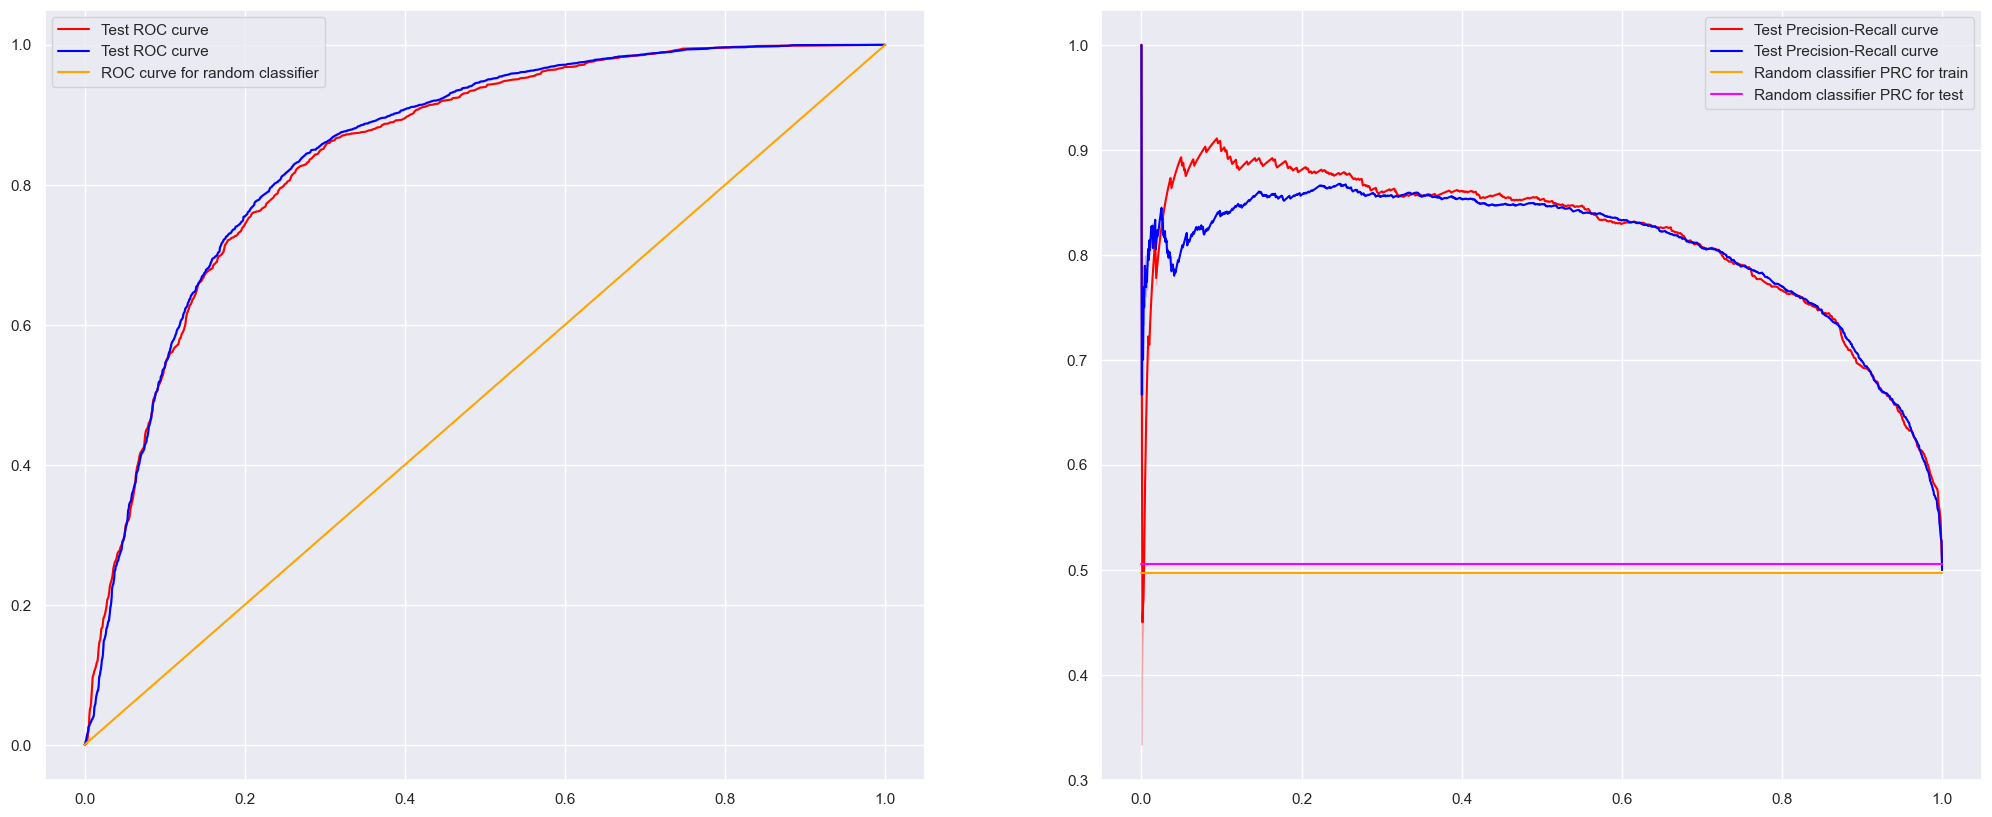

In [9]:
roc_auc_train = roc_auc_score(y_train, train_prediction)
roc_auc_test = roc_auc_score(y_test, test_prediction)

print(f'AUC ROC on Train is {roc_auc_train:.5f}')
print(f'AUC ROC on Test is {roc_auc_test:.5f}')

prc_auc_train = average_precision_score(y_train, train_prediction)
prc_auc_test = average_precision_score(y_test, test_prediction)

print(f'Area Under Precision Recall Curve on Train is {prc_auc_train:.5f}')
print(f'Area Under Precision Recall Curve on Test is {prc_auc_test:.5f}')

prc_test = precision_recall_curve(y_test, test_prediction)
ac_test = roc_curve(y_test, test_prediction)

prc_train = precision_recall_curve(y_train, train_prediction)
ac_train = roc_curve(y_train, train_prediction)

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (25, 10))


sns.lineplot(x = ac_test[0], y = ac_test[1], label='Test ROC curve', color='red', ax=ax[0])
sns.lineplot(x = ac_train[0], y = ac_train[1], label='Test ROC curve', color='blue', ax=ax[0])

sns.lineplot(x = [0,1], y=[0,1], label='ROC curve for random classifier', color='orange', ax=ax[0])

sns.lineplot(x = prc_test[1], y = prc_test[0], label='Test Precision-Recall curve', color='red', ax=ax[1])
sns.lineplot(x = prc_train[1], y = prc_train[0], label='Test Precision-Recall curve', color='blue', ax=ax[1])

sns.lineplot(x = [0,1], y = [sum(y_train)/len(y_train)]*2, label = 'Random classifier PRC for train', color='orange')
sns.lineplot(x = [0,1], y = [sum(y_test)/len(y_test)]*2, label = 'Random classifier PRC for test', color='magenta')

plt.show()

Как видно, на train и test выборках классификаторы дают предсказания лучше случайного. Случайный классификатор в случае ROC curve дает точность равную 0.5. Для precision-recall curve случайный классификатор давал бы предсказание как долю объектов положительного класса, а кривая была бы прямой на уровне $\frac{P}{P+N}$.

C помощью `sklearn` можно посчитать метрики двумя разными способами.

Альтернативный метод для ROC-AUC через метод roc_curve + функция auc

In [10]:
import sklearn
fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_test, test_prediction, pos_label=1)
print(f'ROC-AUC score is {round(sklearn.metrics.auc(fpr,tpr), 5)}')

ROC-AUC score is 0.84781


We get the same result as before.
An alternative method to calculte precision-recall curve is precision_recall_curve function + function auc
We should input labe 

In [11]:
precision, recall, thresholds = sklearn.metrics.precision_recall_curve(y_test, test_prediction)
print(f'PR score is {round(sklearn.metrics.auc(recall,precision), 5)}')

PR score is 0.81528


So, the result is a bit different which is due to functions inplementation
average_precision_score calculates the integral in the following way:

```python
def _binary_uninterpolated_average_precision(
        y_true, y_score, pos_label=1, sample_weight=None
    ):
        precision, recall, _ = precision_recall_curve(
            y_true, y_score, pos_label=pos_label, sample_weight=sample_weight
        )
        # Return the step function integral
        # The following works because the last entry of precision is
        # guarante`ed to be 1, as returned by precision_recall_curve
        return -np.sum(np.diff(recall) * np.array(precision)[:-1])

```

Meanwhile, auc function calculates integral using trapezodial rule and np.trapz in the following way:

```python
def auc(x, y):
    check_consistent_length(x, y)
    x = column_or_1d(x)
    y = column_or_1d(y)

    if x.shape[0] < 2:
        raise ValueError(
            "At least 2 points are needed to compute area under curve, but x.shape = %s"
            % x.shape
        )

    direction = 1
    dx = np.diff(x)
    if np.any(dx < 0):
        if np.all(dx <= 0):
            direction = -1
        else:
            raise ValueError("x is neither increasing nor decreasing : {}.".format(x))

    area = direction * np.trapz(y, x)
    if isinstance(area, np.memmap):
        # Reductions such as .sum used internally in np.trapz do not return a
        # scalar by default for numpy.memmap instances contrary to
        # regular numpy.ndarray instances.
        area = area.dtype.type(area)
    return area
```

А теперь проделайте все то же самое для логистической регрессии (LR) — обучение, подбор параметра регуляризации (используйте L2-регуляризацию), вычисление всех метрик и построение кривых. Сравните результаты LR и SVM с точки зрения всех вычисленных критериев качества, объясните различия (если они есть).

In [12]:
from sklearn.linear_model import LogisticRegression

pipeline = Pipeline(
    [
        ('scaling', StandardScaler()),
        ('regression', LogisticRegression(random_state=42))
    ]
)

params = {'regression__C': np.logspace(-4, 0, 10)}

cv = StratifiedKFold(n_splits=5)
scorer = GridSearchCV(
    estimator=pipeline,
    param_grid=params,
    cv=cv,
)

scorer.fit(X_train, y_train)

print(f"The best parameter C is {scorer.best_params_['regression__C']}")
best_regression = scorer.best_estimator_

The best parameter C is 0.3593813663804626


In [13]:
best_regression.fit(X_train, y_train)

train_prediction = best_regression.predict_proba(X_train)[:, 1]
test_prediction = best_regression.predict_proba(X_test)[:, 1]

AUC ROC on Train is 0.85126
AUC ROC on Test is 0.84787
Area Under Precision Recall Curve on Train is 0.82241
Area Under Precision Recall Curve on Test is 0.82941


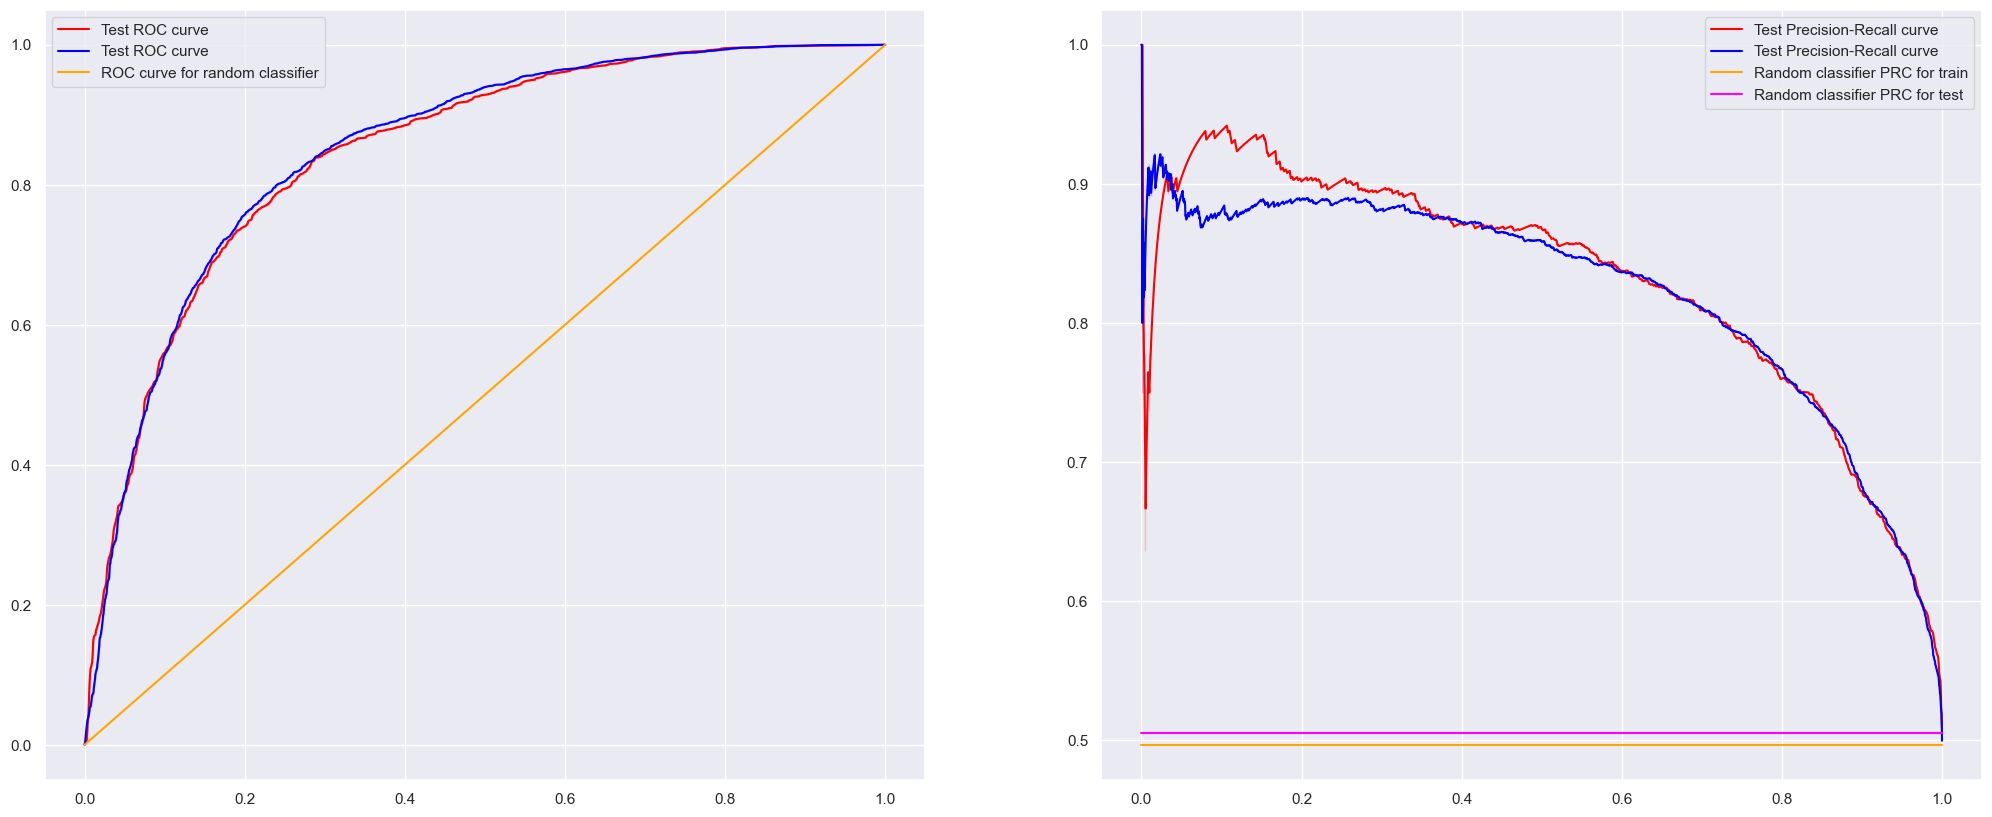

In [14]:
roc_auc_train = roc_auc_score(y_train, train_prediction)
roc_auc_test = roc_auc_score(y_test, test_prediction)

print(f'AUC ROC on Train is {roc_auc_train:.5f}')
print(f'AUC ROC on Test is {roc_auc_test:.5f}')

prc_auc_train = average_precision_score(y_train, train_prediction)
prc_auc_test = average_precision_score(y_test, test_prediction)

print(f'Area Under Precision Recall Curve on Train is {prc_auc_train:.5f}')
print(f'Area Under Precision Recall Curve on Test is {prc_auc_test:.5f}')

prc_test = precision_recall_curve(y_test, test_prediction)
ac_test = roc_curve(y_test, test_prediction)

prc_train = precision_recall_curve(y_train, train_prediction)
ac_train = roc_curve(y_train, train_prediction)

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (25, 10))


sns.lineplot(x = ac_test[0], y = ac_test[1], label='Test ROC curve', color='red', ax=ax[0])
sns.lineplot(x = ac_train[0], y = ac_train[1], label='Test ROC curve', color='blue', ax=ax[0])

sns.lineplot(x = [0,1], y=[0,1], label='ROC curve for random classifier', color='orange', ax=ax[0])

sns.lineplot(x = prc_test[1], y = prc_test[0], label='Test Precision-Recall curve', color='red', ax=ax[1])
sns.lineplot(x = prc_train[1], y = prc_train[0], label='Test Precision-Recall curve', color='blue', ax=ax[1])

sns.lineplot(x = [0,1], y = [sum(y_train)/len(y_train)]*2, label = 'Random classifier PRC for train', color='orange')
sns.lineplot(x = [0,1], y = [sum(y_test)/len(y_test)]*2, label = 'Random classifier PRC for test', color='magenta')

plt.show()

The results are a bit different:
SVM has .84781 test ROC-AUC while LogReg has .84787 test ROC-AUC which is a bit higher
SVM has .81567 test PRC-score while LogReg has .82941 test PRC-score which is also a bit higher

It means that Logistic reagression copes a bit better with the task given the set of data

Сгенерируйте синтетический набор данных с помощью функции `make_classification(..)` с числом признаков, равным 2 для выполнения следующего (**и только следующего задания**) задания.

Логистическая регрессия приближает в каждой точке пространства объектов правдоподобие положительных ответов $p(y=+1|x)$. Попробуйте нарисовать это распределение на плоскости, не забудьте отметить на ней все объекты. Вам может помочь функция `plt.pcolor`.

In [28]:
X, y = make_classification(
    n_samples=10000, n_features=2, n_informative=2, n_redundant=0,
    random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=42)

In [40]:
X_train[:, 1].min()

-5.049090666105036

In [29]:
model = LogisticRegression(penalty='l2', C=0.01)
model.fit(X_train, y_train)

preds = model.predict_proba(X_test)[:, 1]

In [75]:
y_list = []
X = np.arange(-4.494161554502019, 3.853139914200362, 0.05)
for X_1 in np.arange(-4.475267425400133, 2.907667629000339, 0.05):
    y_pred = model.predict_proba(np.vstack(((np.ones((1,len(X))) * (X_1)), X)).T)[:,1]
    y_list.append(list(y_pred))

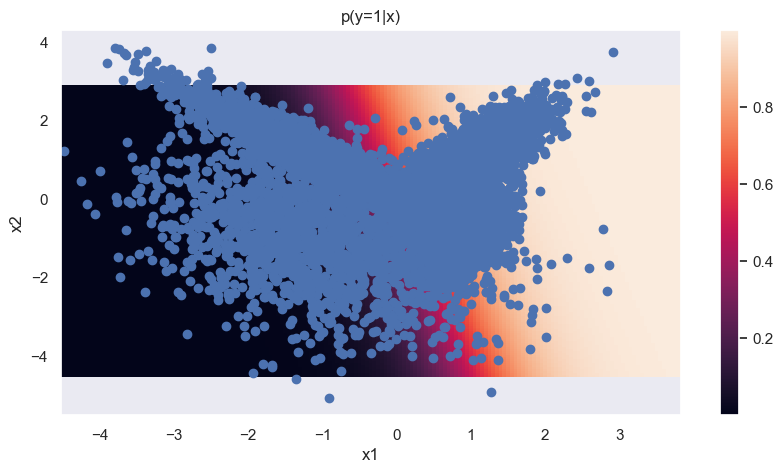

In [77]:
plt.figure(figsize=(10,5))

plt.pcolor(X, np.arange(-4.475267425400133, 2.907667629000339, 0.05), y_list)
plt.colorbar()
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('p(y=1|x)')

plt.scatter(X_train[:, 0], X_train[:, 1]);

__Задание 2.__ Калибровка вероятностей.

__(1 балл)__

Перейдём к оценке качества выдаваемых алгоритмами вероятностей. Начнём с калибровочных кривых. 

Допустим, алгоритм возвращает некоторые числа от нуля до единицы. Хорошо ли они оценивают вероятность? Для этого разобьем отрезок $[0, 1]$ на несколько маленьких отрезков одинаковой длины. Рассмотрим $i$-й отрезок с границами $[a_i, b_i]$ и предсказания $p_1, p_2, \dots, p_k$, которые попали в него. Пусть им соответствуют истинные ответы $y_1, y_2, \dots, y_k$. Если алгоритм выдает корректные вероятности, то среди этих истинных ответов должно быть примерно $(a_i + b_i) / 2$ единиц. Иными словами, если нарисовать кривую, у которой по оси X отложены центры отрезков, а по оси Y — доли единичных ответов этих в отрезках, то она должна оказаться диагональной. Ниже приведена функция, которая должна рисовать такие кривые. В ней допущено две ошибки — найдите и исправьте их.

In [17]:
def plot_calibration_curve(y_test, preds):
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 10
    for i in range(n_bins):
        l = 1.0 / n_bins * i
        r = 1.0 / n_bins * (i + 1) 
        bin_middle_points.append((l + r) / 2) # mistake 1
        bin_real_ratios.append(np.mean(y_test[(preds >= l) & (preds < r)] == 1)) # mistake 2
    plt.figure(figsize=(6,6))
    plt.plot(bin_middle_points, bin_real_ratios)
    plt.ylim([-0.05, 1.05])
    plt.grid()
    plt.title('Calibration curve')
    plt.plot([0, 1], [0, 1], linestyle='dashed')

Сгенерируйте синтетический датасет аналогично использованному в самом первом задании — он будет выступать в качестве тестовой выборки. Постройте калибровочные кривые на тестовой части для логистической регрессии и метода опорных векторов (не забудьте перевести его предсказания в $[0;1]$). Изучите распределение ответов классификаторов (постройте гистограммы с помощью `plt.hist`). Чем они различаются? Чем вы можете объяснить это?

In [18]:
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5,
    random_state=42)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)


### Logistic regression 

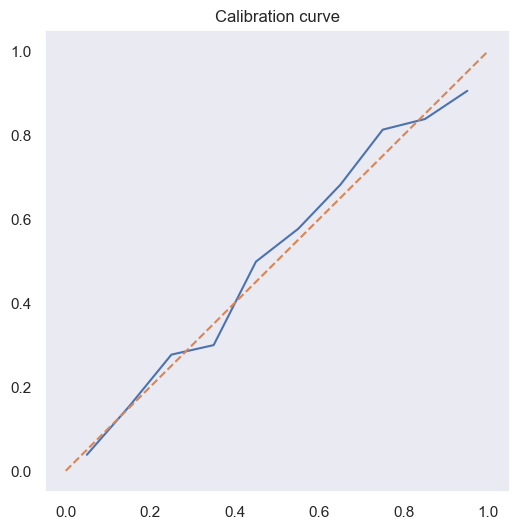

In [19]:
lr = LogisticRegression(C=100)
lr.fit(X_train, y_train)
lr_preds = lr.predict_proba(X_test)[:, 1]
plot_calibration_curve(y_test, lr_preds)

### SVM

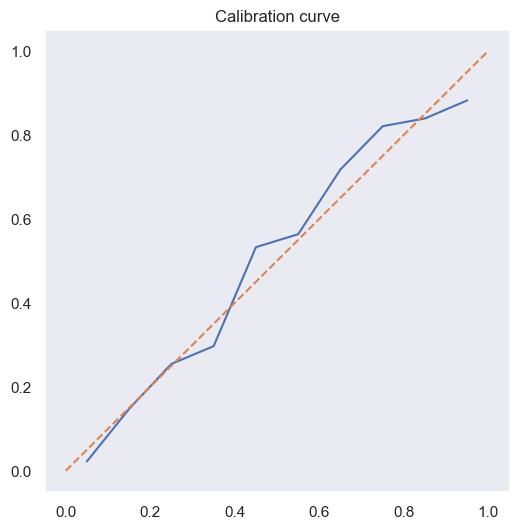

In [20]:
svc = SVC(kernel = 'linear', 
          random_state=42,
          probability=True,
          C=0.01)

svc.fit(X_train, y_train)
svc_preds = svc.predict_proba(X_test)[:, 1]
plot_calibration_curve(y_test, svc_preds)

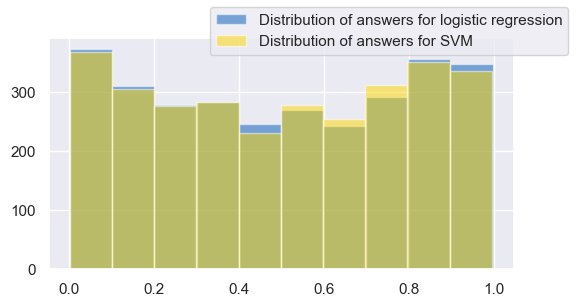

In [21]:
fig, ax = plt.subplots(figsize=(6,3))

ax.hist(lr_preds, color='#0057b7', label='Distribution of answers for logistic regression', alpha=0.5)
ax.hist(svc_preds, color='#ffd700', label='Distribution of answers for SVM', alpha=0.5)
fig.legend();

As we can see the distribution of answers is identical at the lower part of probabilities. However, SVM has higher values of density at the right part of unit interval. Why do they differ? 

Воспользуйтесь `CalibratedClassifierCV` из `sklearn` для калибровки вероятностей метода опорных векторов на обучении и постройте с его помощью предсказания для тестовой выборки. Нарисуйте для них калибровочную кривую. Улучшилась ли она?

### SVM calibrated

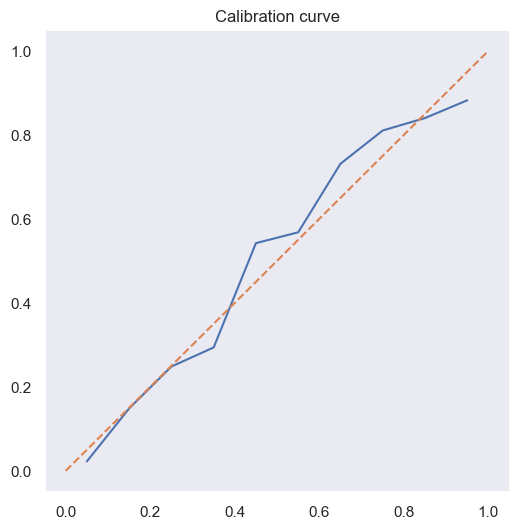

In [22]:
from sklearn.calibration import CalibratedClassifierCV

svc = SVC(kernel='linear', probability=True)

calibrated_clf = CalibratedClassifierCV(base_estimator=svc, cv=5)
calibrated_clf.fit(X_train, y_train)
svc_preds_calibrated = calibrated_clf.predict_proba(X_test)[:, 1]

plot_calibration_curve(y_test, svc_preds_calibrated)

After calibration the curve is more alligned with diagonal line

# Часть 1. Работа с переменными.

В этой части мы научимся обрабатывать категориальные переменные, так как закодировать их в виде чисел недостаточно (это задаёт некоторый порядок, которого на категориальных переменных может и не быть). Существует два основных способа обработки категориальных значений:
- One-hot-кодирование
- Счётчики (CTR, mean-target кодирование, ...) — каждый категориальный признак заменяется на среднее значение целевой переменной по всем объектам, имеющим одинаковое значение в этом признаке.

Начнём с one-hot-кодирования. Допустим наш категориальный признак $f_j(x)$ принимает значения из множества $C=\{c_1, \dots, c_m\}$. Заменим его на $m$ бинарных признаков $b_1(x), \dots, b_m(x)$, каждый из которых является индикатором одного из возможных категориальных значений:
$$
b_i(x) = [f_j(x) = c_i]
$$

__Подготовка данных.__

Загрузим данные [UCI Bank Marketing Dataset](https://archive.ics.uci.edu/ml/datasets/bank+marketing). Этот датасет содержит информацию о банковском телефонном маркетинге, объектом в нем является телефонный звонок потенциальному клиенту с предложением некоторой услуги (утверждается, что это краткосрочный депозит), целевой переменной - ответ клиента (согласился ли он открыть депозит?). В качестве признакового описания используются характеристики клиента (образование, брак и т.д.), данные о звонке и различные экономические индикаторы - более подробная информация представлена в файле `bank-additional-names.txt`.

In [23]:
#!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
#!unzip bank-additional.zip
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

__Задание 3 (0.5 балла).__ Разделите выборку на обучающую и тестовую в соотношении 3:1. Зафиксируйте `random_state=777`, также используйте `stratify`. Один из столбцов в данных не несет информации для решения задачи — какой? Отбросьте его. 



In [24]:
# duration doesn't make sense for prediction beacuse we don't know the duration of the call before the call happens
X = df.drop(columns=['duration', 'y'])
y = (df.y == 'yes')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=777, stratify=y)

Закодируйте категориальные признаки с помощью `OrdinalEncoder`. Посчитайте качество (в этом задании будем работать c `AUC-PR`) при применении логистической регрессии. Замерьте время, потребовавшееся на обучение модели (с учетом кодирования признаков).

__Вопрос__: почему в данном задании мы выбрали метрикой именно `AUC-PR`, а не, к примеру, `AUC-ROC`?

__Ваш ответ__:

In [25]:
# divide the variables

cat_cols = ['job', 'marital', 'education', 
            'default', 'housing', 'loan', 'contact', 
            'month', 'day_of_week', 'pdays', 'poutcome']

num_cols = ['age', 'campaign', 'previous', 'emp.var.rate', 
            'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']

In [26]:
%time
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

trasformer = ColumnTransformer(
    [
        ('scaler', StandardScaler(), num_cols),
        ('oe', OrdinalEncoder(), cat_cols)
    ]
)

pipeline = Pipeline(
    [
        ('trasformer', trasformer),
         ('regression', LogisticRegression(penalty='l2', C=100))
    ]
)

pipeline.fit(X_train, y_train)
preds_oe = pipeline.predict_proba(X_test)[:, 1]

print(f'Test AUC-PR score is {average_precision_score(y_test, preds_oe, pos_label=1)}')

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.05 µs
Test AUC-PR score is 0.43902015530721994


__Задание 4 (0.5 балла).__ Закодируйте все категориальные признаки с помощью one-hot-кодирования. Обучите логистическую регрессию и посмотрите, как изменилось качество модели (с тем, что было до кодирования). Измерьте время, потребовавшееся на кодирование категориальных признаков и обучение модели.



In [27]:
%time
from sklearn.preprocessing import OneHotEncoder

trasformer = ColumnTransformer(
    [
        ('scaler', StandardScaler(), num_cols),
        ('oe', OneHotEncoder(), cat_cols)
    ]
)

pipeline = Pipeline(
    [
        ('trasformer', trasformer),
         ('regression', LogisticRegression(penalty='l2', C=100))
    ]
)

pipeline.fit(X_train, y_train)
preds_oe = pipeline.predict_proba(X_test)[:, 1]

print(f'Test AUC-PR score is {average_precision_score(y_test, preds_oe, pos_label=1)}')

CPU times: user 2 µs, sys: 7 µs, total: 9 µs
Wall time: 4.29 µs
Test AUC-PR score is 0.44391229074291566


AUC-PR score is better with OHE, however in this case the computation takes a bit more time

Как можно было заменить, one-hot-кодирование может сильно увеличивать количество признаков в датасете, что сказывается на памяти, особенно, если некоторый признак имеет большое количество значений. Эту проблему решает другой способ кодирования категориальных признаков — счётчики. Основная идея в том, что нам важны не сами категории, а значения целевой переменной, которые имеют объекты этой категории. Каждый категориальный признак мы заменим средним значением целевой переменной по всем объектам этой же категории:
$$
g_j(x, X) = \frac{\sum_{i=1}^{l} [f_j(x) = f_j(x_i)][y_i = +1]}{\sum_{i=1}^{l} [f_j(x) = f_j(x_i)]}
$$

__Задание 5 (1 балл).__ Закодируйте категориальные переменные с помощью счётчиков (ровно так, как описано выше без каких-либо хитростей). Можете воспользоваться [библиотекой](https://contrib.scikit-learn.org/category_encoders/targetencoder.html) с четвертого семинара или написать класс сами. Обучите логистическую регрессию и посмотрите на качество модели на тестовом множестве. Сравните время обучения с предыдущими экспериментами (с учетом кодирования признаков). Заметили ли вы что-то интересное?


In [28]:
from category_encoders import TargetEncoder

In [29]:
%time
# here I will use library from section 4
# First I do it without smoothing or min_sample_leaf

trasformer = ColumnTransformer(
    [
        ('scaler', StandardScaler(), num_cols),
        ('oe', TargetEncoder(cols=cat_cols, handle_missing = 'value',
                             handle_unknown = 'value',
                             smoothing = 0), cat_cols)
    ]
)

pipeline = Pipeline(
    [
        ('trasformer', trasformer),
         ('regression', LogisticRegression(penalty='l2'))
    ]
)

pipeline.fit(X_train, y_train)
preds_oe = pipeline.predict_proba(X_test)[:, 1]

print(f'Test AUC-PR score is {average_precision_score(y_test, preds_oe, pos_label=1)}')

CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 3.1 µs
Test AUC-PR score is 0.4399105332742697


The quality is a bit lower then with OneHotEncoder, the speed is almost the same

А теперь ответьте на следующий вопрос: что будет, если некоторая категория встречается в выборке всего несколько раз? По этой причине производится сглаживание счётчиков. Например, на практике хорошие результаты показывает использование сглаживания средним по всей выборке:
$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1] + C \times global\_mean}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)] + C}
$$
где $global\_mean$ — доля объектов положительного класса в выборке, $C$ — параметр, определяющий степень сглаживания. Основная идея в том, что мы "разбавляем" среднее значение по некоторой категории глобальным средним значением. И тем меньше, чем большее количество объектов этой категории встречается в выборке. 

Однако для сглаживания вместо среднего значения целевой переменной можно использовать любое другое значение от 0 до 1 (этот параметр иногда называют $prior$). Можно сделать несколько признаков с разными значениями параметра. На практике в задачах бинарной классификации полезными бывают даже отрицательные значения!


The promlem here is overfitting. Relying on average value is not a good idea when the numbers of values used to calculate the average is low. That is why we use smoothing. 

__Задание 6 (1 балл).__ Добавьте сглаживание, описанное выше и повторите эксперименты.

In [30]:
%time
# With smoothing
from category_encoders import TargetEncoder

trasformer = ColumnTransformer(
    [
        ('scaler', StandardScaler(), num_cols),
        ('oe', TargetEncoder(cols=cat_cols,
                             handle_missing = 'value',
                             handle_unknown = 'value',
                             smoothing = 0.1), cat_cols)
    ]
)

pipeline = Pipeline(
    [
        ('trasformer', trasformer),
         ('regression', LogisticRegression(penalty='l2'))
    ]
)

pipeline.fit(X_train, y_train)
preds_oe = pipeline.predict_proba(X_test)[:, 1]

print(f'Test AUC-PR score is {average_precision_score(y_test, preds_oe, pos_label=1)}')

CPU times: user 5 µs, sys: 5 µs, total: 10 µs
Wall time: 4.05 µs
Test AUC-PR score is 0.4402804464461013


__Замечание.__ Усложнение методов вычисления счётчиков не делают результаты модели гарантированно лучше. Особенно с учётом того, что логистическая регрессия не такая сложная модель, чтобы переобучаться. Поэтому вы необязательно должны были получать на каждом шаге всё лучшие и лучшие результаты (но необходимые результаты у вас должны были получиться).

Как вы должны были заметить, счётчики являются хорошей альтернативой one-hot-кодированию. Напишите, какие плюсы и минусы использования счётчиков по сравнению с one-hot-кодированием вы заметили.

__Ответ:__ 

Плюсы:

+ Большая скорость вычислений 
+ Отсутствие проклятия размерности + более эффективное использование памяти

Минусы:

+ Возможное переобучение и утечка данных из целевой переменной
+ Сильное понижение предсказательной способности при наличие domain shift между train и test выборками

# Часть 2. Отбор признаков

Важной частью процесса построения модели является отбор признаков. На практике многие признаки оказывают малое влияние на модель (при этом их расчёт занимает время) или даже негативно сказываются на качестве модели. Попробуем несколько подходов отбора признаков, оценим, как они влияют на качество модели и сколько времени занимают.

Обратимся к тому же датасету про банковский телефонный маркетинг.

In [31]:
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

X = df.drop(columns=['duration', 'y'])
y = (df.y == 'yes')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=777, stratify=y)

Как вы помните, в данных много категориальных признаков (сейчас давайте интерпретировать возраст как числовой). Давайте закодируем их с помощью one-hot кодирования. Исходные колонки с категориальными признаками можно удалить. Сколько признаков мы получили?

В качестве основной модели будем использовать логистическую регрессию, а целевой метрики — `AUC-PR`. Обучите модель и посчитайте качество на тестовой выборке. Давайте запомним полученное значение.

In [32]:
# do everything without normalization
transformer = ColumnTransformer(
    [
        ('ohe', OneHotEncoder(), cat_cols)
    ]
)

pipeline = Pipeline(
    [
        ('transformer', transformer),
        ('regression', LogisticRegression())
    ]
)

pipeline.fit(X_train, y_train)
preds_oe = pipeline.predict_proba(X_test)[:, 1]

print(f'Test AUC-PR score is {average_precision_score(y_test, preds_oe, pos_label=1)}')


Test AUC-PR score is 0.4074889101591114


### Встроенные методы

Допустим, мы хотим оставить только 40 лучших признаков. Попробуем сделать это несколькими способами.

Начнём с отборам признаков с помощью линейной модели. Как известно, веса линейной модели означают вклад каждого признака в предсказание модели, а значит, модуль этого вклада можно интерпретировать как важность признаков. Такой метод отбора называются встроенным или embedded methods, так как он заложен в особенности модели.

__Задание 7 (0.5 балла).__ Оставьте 40 признаков с наибольшим модулем соответствующего параметра линейной модели. Обучите модели заново и оцените её качество. Замерьте скорость такого отбора признаков.

Изменилось ли качество? Как?



In [33]:
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import OneHotEncoder

In [34]:
transformer = ColumnTransformer(
    [
        ('ohe', OneHotEncoder(), cat_cols)
    ]
)

pipeline = Pipeline(
    [
        ('transformer', transformer),
        ('selector', SelectFromModel(estimator=LogisticRegression(), max_features=40, threshold=0.001)),
        ('regression', LogisticRegression())
    ]
)

pipeline.fit(X_train, y_train)
preds = pipeline.predict_proba(X_test)[:, 1]

print(f'Test AUC-PR score is {average_precision_score(y_test, preds, pos_label=1)}')

Test AUC-PR score is 0.40344737163393


In [35]:
# We have limited the number of features to 40 by coef_ value criterion
pipeline.named_steps.regression.n_features_in_

40

In [36]:
# Let us reassure that we have done the right thing
np.sort(np.abs(pipeline.named_steps.regression.coef_))

array([[0.06845286, 0.09048582, 0.13211764, 0.13850106, 0.14099802,
        0.18005816, 0.21721449, 0.22071944, 0.2438487 , 0.29034771,
        0.29181238, 0.32406468, 0.32480788, 0.34827318, 0.35295206,
        0.37309753, 0.38706273, 0.39079967, 0.3971353 , 0.40127468,
        0.44810125, 0.45937966, 0.5241076 , 0.53258764, 0.56015176,
        0.62220242, 0.62643551, 0.63616375, 0.64906745, 0.69559153,
        0.72163058, 0.76076813, 0.79233646, 0.81334036, 0.82532414,
        0.87235569, 1.14426092, 1.15469397, 1.41929744, 1.75554399]])

А теперь давайте подумаем, что мы не учли. Мы предположили, что признаки вносят вклад равномерно, но не учли их масштаба. Если мы умножим один из признаков в 100 раз, то без учёта регуляризации его вес уменьшится в эти же 100 раз. А мы на основе этого отбираем признаки! Давайте сначала отмасштабируем признаки одним из способов, а только потом будем удалять признаки. 

Кстати, в таком случае надо пересчитать качество на всех признаках (сделайте это ниже). Если вы сделали нормирование признаков в самом начале, то попробуйте отобрать признаки на неотмасштабированных данных.

Что получилось?

In [37]:
transformer = ColumnTransformer(
    [
        ('ohe', OneHotEncoder(), cat_cols),
        ('scaler', StandardScaler(), num_cols)
    ]
)

pipeline = Pipeline(
    [
        ('transformer', transformer),
        ('selector', SelectFromModel(estimator=LogisticRegression(), max_features=40, threshold=0.001)),
        ('regression', LogisticRegression())
    ]
)

pipeline.fit(X_train, y_train)
preds = pipeline.predict_proba(X_test)[:, 1]

print(f'Test AUC-PR score is {average_precision_score(y_test, preds, pos_label=1)}')

Test AUC-PR score is 0.44378984549608635


In [38]:
# We have limited the number of features to 40 by coef_ value criterion
pipeline.named_steps.regression.n_features_in_

40

In [39]:
# Let us reassure that we have done the right thing
np.sort(np.abs(pipeline.named_steps.regression.coef_))

array([[0.05271939, 0.05423304, 0.09459214, 0.11833901, 0.13405479,
        0.14575152, 0.1700933 , 0.18252174, 0.21419303, 0.21522469,
        0.22316617, 0.26477513, 0.26619944, 0.29685324, 0.30132324,
        0.32788697, 0.34121947, 0.34363185, 0.34463664, 0.36234739,
        0.36352424, 0.38384578, 0.38500691, 0.4071011 , 0.41210718,
        0.4529337 , 0.51420279, 0.52602788, 0.53702998, 0.54565319,
        0.55187819, 0.55373235, 0.55963237, 0.68006767, 0.91865287,
        0.99389775, 1.10942266, 1.18891453, 1.31386155, 2.19988776]])

The score is the same and the coefficients are almost the same. I think that is because categorical features are more inportant here than numberical and numberical features are just thrown out during the feature selection.

Вопрос на засыпку: one-hot кодирование возвращает нам единичные признаки-индикаторы. Попробуйте также отскалировать их, как и обычные числовые, и снова выбрать 40 главных по вкладу признаков. Изменился ли их список? Изменится ли качество?

In [40]:
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

y = (df.y == 'yes')

X_num = df[num_cols]
X_cat = df[cat_cols]

X_cat = pd.get_dummies(X_cat)

X = pd.concat([X_num, X_cat], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=777, stratify=y)

In [41]:
transformer = ColumnTransformer(
    [
        ('scaler', StandardScaler(), list(X_train.columns))
    ]
)

pipeline = Pipeline(
    [
        ('transformer', transformer),
        ('selector', SelectFromModel(estimator=LogisticRegression(), max_features=40, threshold=0.001)),
        ('regression', LogisticRegression())
    ]
)

pipeline.fit(X_train, y_train)
preds = pipeline.predict_proba(X_test)[:, 1]

print(f'Test AUC-PR score is {average_precision_score(y_test, preds, pos_label=1)}')

Test AUC-PR score is 0.44867557999698787


In [42]:
# Let us reassure that we have done the right thing
np.sort(np.abs(pipeline.named_steps.regression.coef_))

array([[0.00809986, 0.01117192, 0.0182066 , 0.01980593, 0.02345605,
        0.02482663, 0.02844368, 0.02860289, 0.02908421, 0.03019122,
        0.03723946, 0.03953179, 0.04296281, 0.04321328, 0.0458586 ,
        0.04622273, 0.04900194, 0.05225601, 0.0531471 , 0.05445557,
        0.05805198, 0.0670337 , 0.08081463, 0.08200663, 0.09027468,
        0.11155437, 0.13198841, 0.13535067, 0.13885836, 0.15098625,
        0.17787066, 0.17787066, 0.17853289, 0.18648775, 0.2203664 ,
        0.23334969, 0.24831327, 0.55473594, 1.24514105, 2.32826245]])

The coefficeints changed a bit, categorical features are now scaled. However those are the same coefficients and dame features, becase scaling doesn't matter for a feature that represents a category

### Методы фильтрации


Давайте отбирать признаки умнее, а именно через подсчёт некоторой функции для каждого признака. На основании значений этой функции будем оставлять наиболее важные признаки. Методы этого семейства называют фильтрующими или  filter methods. 

В качестве такой функции будем считать t-статистику:

$$t(j) = \frac{|\mu_+ - \mu_-|}{\sqrt{\frac{n_+ \sigma^2_+ + n_- \sigma^2_-}{n_+ + n_-}}},$$

где $\mu$, $\sigma$, $n$ соответственно среднее, стандартное отклонение и количество объектов каждого из классов.

__Задание 8 (0.5 балла).__ Оставьте 40 признаков с наибольшим значением $t$ и замерьте качество. Не забудьте замерить скорость отбора признаков в этом случае.



Fist, we do one-hot encoding

In [43]:
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

In [44]:
df.drop(columns=['duration'], inplace=True)

In [45]:
# First we get dummy cols for the whole dataset
y = (df.y == 'yes')
X = df.drop(columns=['y'])

In [46]:
cat = pd.get_dummies(X[cat_cols], drop_first=True)
num = X[num_cols]

X_new = pd.concat([num, cat], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=777, stratify=y)

In [47]:
# calculate best features base on t_stat
train_t_stat = pd.DataFrame(columns=X_train.columns)

In [48]:
# get subsets with positive and negative target values
train_pos = X_train[y_train]
train_neg = X_train[~y_train]

def t_stat(pos, neg):
    return np.abs(np.mean(pos) - np.mean(neg)) \
        / np.sqrt((len(pos)*np.var(pos) + len(neg)*np.var(neg))/(len(pos) + len(neg)))
        
for col in X_train.columns:
    train_t_stat.loc[0, col] = t_stat(train_pos[col], train_neg[col])
    
top_40_features = list(train_t_stat.T[0].sort_values(ascending=False)[:40].index)

train_cat = X_train[list(cat.columns)].reset_index(drop=True)
test_cat = X_test[list(cat.columns)].reset_index(drop=True)

scaler = StandardScaler()

train_num = pd.DataFrame(scaler.fit_transform(X_train[num_cols]), 
                           columns = X_train[num_cols].columns).reset_index(drop=True)
test_num = pd.DataFrame(scaler.fit_transform(X_test[num_cols]), 
                          columns = X_test[num_cols].columns).reset_index(drop=True)

X_train = pd.concat([train_cat, train_num], axis=1)
X_test = pd.concat([test_cat, test_num], axis=1)

log_reg = LogisticRegression(penalty='l2', max_iter=10000)
results = log_reg.fit(X_train[top_40_features], y_train)

preds = results.predict_proba(X_test[top_40_features])[:, 1]

print(f'Test AUC-PR score is {average_precision_score(y_test, preds)}')

Test AUC-PR score is 0.4455319274750233


We have managed to slightly improve the result

### Методы-обёртки

__Задание 9 (1 балл).__ 

Третий из рассматриваемых нами методов работает следующим образом: мы исключаем по очереди один из признаков и смотрим, как это влияет на качество. Удаляем признаки таким жадным способом, пока не окажется выполненым некоторое условие (количество признаков или ухудшение качества).

Заметим, что нельзя оценивать качество по тестовой выборке, иначе мы можем переобучиться, как, например, при настройке гиперпараметров. Разделите обучающую выборку на 2 части, на одной из них обучайте модель без одного из признаков,  на второй части оценивайте качество. Исходную тестовую выборку стоит использовать только для финальной оценки качества.

Снова оставьте только 40 признаков и оцените качество на тестовой выборке. Сколько времени занял такой отбор признаков?

In [49]:
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')
df.drop(columns=['duration'], inplace=True)

# First we get dummy cols for the whole dataset
y = (df.y == 'yes')
X = df.drop(columns=['y'])

cat = pd.get_dummies(X[cat_cols], drop_first=True)
num = X[num_cols]

X_new = pd.concat([num, cat], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=777, stratify=y)

cat_cols = ['job', 'marital', 'education', 
            'default', 'housing', 'loan', 'contact', 
            'month', 'day_of_week', 'pdays', 'poutcome']

num_cols = ['age', 'campaign', 'previous', 'emp.var.rate', 
            'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']

In [50]:
from sklearn.feature_selection import RFE
from sklearn.model_selection import StratifiedKFold

In [51]:
lr = LogisticRegression()
rfe = RFE(estimator=lr, n_features_to_select=40, step=1)
rfe.fit(X_train, y_train)

RFE(estimator=LogisticRegression(), n_features_to_select=40)

In [52]:
X_train_mat = rfe.transform(X_train)
X_test_mat = rfe.transform(X_test)

In [53]:
lr = LogisticRegression()
lr.fit(X_train_mat, y_train)
preds = lr.predict(X_test_mat)

In [54]:
print(f'Test AUC-PR score is {average_precision_score(y_test, preds, pos_label=1)}')

Test AUC-PR score is 0.21286225339006065


Давайте подведём итоги по отбору признаков. Назовите преимущества и недостатки каждого из методов. Какой метод привёл к наилучшему качеству?

**Ответ:** 

+ Embedded метод фильтрации довльно просто интерпретировать. Также он довольно дешевый по затратам на вычисления и довольно неплохо отбирает признаки.

+ Метод фильтрации также достаточно просто интерпретировать и по вычислениям он не сильно дороже первого метода, однако занимает чуть больше времени.

+ Метод обертки самый дорогой по вычислению. Тем более он представляет из себя жадный алгоритм, который не всегда будет оптимален, поэтому я бы его не стал использовать. Особенно при большом количество признаков и малом шаге. К тому же он дал наихудший результат.

# Часть 3. Оценка экономического эффекта модели

В данной части мы займемся тем, что от вас скорее всего потребуется на реальной работе (помимо перекладки `json`, разумеется). А именно: мы соберем несколько специализированных метрик качества, попытаемся настроить модель на максимизацию _прибыли_ и оценим, сколько вообще получится заработать на этом. Разумеется, здесь будет сделано множество упрощающих жизнь допущений, но обо всем по порядку. 

__Задание 10 (1.5 балл).__ Допустим, работники вашего колл-центра получают за один звонок клиенту 1 доллар. При согласии клиента на предлагаемые условия он принесет в банк 10 долларов.

Если вы всё прослушали на экономике, то напомним, что выручка — это сколько денег нам принесли клиенты, а прибыль — выручка за вычетом расходов на зарплату и прочее.

Загрузите данные о телемаркетинге из предыдущего блока заданий. В этой части не нужно делить выборку - мы будем использовать кросс-валидацию. Используйте 5 фолдов, сделайте `shuffle=True, random_state=500`. По кросс-валидации у вас получится 5 вариантов обучающей и тестовой выборки. Обучите логистическую регрессию на каждой обучающей выборке (воспользуйтесь one-hot для категориальных признаков, гиперпараметры оставьте со значениями по умолчанию) и сделайте предсказания (`predict(...)`) для соответствующих тестовых выборок. Допустим, всем положительным прогнозам ваши сотрудники решили позвонить. Посчитайте на всех тестовых выборках выручку и усредните. Сколько денег вы в среднем заработаете? Также вычислите стандартное отклонение.

Сколько из заработанных денег придётся отдать операторам вашего колл-центра?

In [55]:
from sklearn.model_selection import KFold

In [56]:
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

X = df.drop(columns=['duration', 'y'])
y = (df.y == 'yes')

In [57]:
lr = LogisticRegression()

cv = KFold(5, shuffle=True, random_state=42)

In [58]:
c = []
i = []
p = []

for train_index, test_index in cv.split(y):
    
    X_train, X_test = X.loc[train_index, :], X.loc[test_index, :]
    y_train, y_test = y[train_index], y[test_index]
    
    transformer = ColumnTransformer(
        [
            ('ohe', OneHotEncoder(handle_unknown='ignore'), cat_cols),
            ('scaler', StandardScaler(), num_cols)
        ]
    )
    
    pipeline = Pipeline(
        [
            ('transformer', transformer),
            ('regression', LogisticRegression())
        ]
    )
    
    pipeline.fit(X_train, y_train)
    preds = pipeline.predict(X_test)
    
    mask = ((preds == True) & (y_test == True))
    
    c.append(np.sum(preds)) # cost
    i.append(np.sum(mask) * 10)
    p.append(np.sum(mask) * 10 - np.sum(preds))
    
print(f'Mean costs is {np.mean(c)} with sdt = {np.std(c)}')
print(f'Mean income is {np.mean(i)} with sdt = {np.std(i)}')
print(f'Mean profit is {np.mean(p)} with sdt = {np.std(p)}')

Mean costs is 316.2 with sdt = 18.465102220134064
Mean income is 2094.0 with sdt = 103.4601372510205
Mean profit is 1777.8 with sdt = 86.17749126076949


Внесем некоторую долю случайности. Пусть теперь согласный на условия клиент будет приносить не 10 долларов, а случайную величину, равномерно распределенную в интервале $[0;20)$. Проделайте все те же самые действия. Для имитации реальной ситуации **НЕ** фиксируйте `random_seed` при подсчете выручки с клиента. Что получилось?

In [59]:
c = []
i = []
p = []

for train_index, test_index in cv.split(y):
    
    X_train, X_test = X.loc[train_index, :], X.loc[test_index, :]
    y_train, y_test = y[train_index], y[test_index]
    
    transformer = ColumnTransformer(
        [
            ('ohe', OneHotEncoder(handle_unknown='ignore'), cat_cols),
            ('scaler', StandardScaler(), num_cols)
        ]
    )
    
    pipeline = Pipeline(
        [
            ('transformer', transformer),
            ('regression', LogisticRegression())
        ]
    )
    
    pipeline.fit(X_train, y_train)
    preds = pipeline.predict(X_test)
    
    mask = ((preds == True) & (y_test == True))
    
    c.append(np.sum(preds)) # cost
    i.append(np.dot(mask, np.random.uniform(low=0, high=20, size=len(mask))))
    p.append(np.dot(mask, np.random.uniform(low=0, high=20, size=len(mask))) - np.sum(preds) * 1)
    
print(f'Mean costs is {np.mean(c)} with sdt = {np.std(c)}')
print(f'Mean income is {np.mean(i)} with sdt = {np.std(i)}')
print(f'Mean profit is {np.mean(p)} with sdt = {np.std(p)}')

Mean costs is 316.2 with sdt = 18.465102220134064
Mean income is 2049.3239336764063 with sdt = 103.59440191383683
Mean profit is 1733.6119492808116 with sdt = 138.04900056663632


Настройте по кросс-валидации коэффициент регуляризации модели для максимизации прибыли (считайте как случайную величину выше). Удалось ли получить какой-то выигрыш? При каком коэффициенте регуляризациии прибыль максимальна? Постройте график зависимости ожидаемой прибыли от коэффициента, также укажите стандартные отклонения (вам поможет `plt.errorbar`).

In [60]:
c_param = np.logspace(-4, 2, 10)

In [61]:
profit_mean = []
profit_std = []

for c in c_param:
    profit = []
    for train_index, test_index in cv.split(y):
        
        X_train, X_test = X.loc[train_index, :], X.loc[test_index, :]
        y_train, y_test = y[train_index], y[test_index]
        
        transformer = ColumnTransformer(
            [
                ('ohe', OneHotEncoder(handle_unknown='ignore'), cat_cols),
                ('scaler', StandardScaler(), num_cols)
            ]
        )
        
        pipeline = Pipeline(
            [
                ('transformer', transformer),
                ('regression', LogisticRegression(C = c))
            ]
        )
        
        pipeline.fit(X_train, y_train)
        preds = pipeline.predict(X_test)
        
        profit.append(np.dot(mask, np.random.uniform(low=0, high=20, size=len(mask))) - np.sum(preds) * 1)
    print(f'For C = {c} mean profit is {np.mean(profit)} with std = {np.std(profit)}')
    profit_mean.append(np.mean(profit))
    profit_std.append(np.std(profit))
    
    

For C = 0.0001 mean profit is 2089.970013829769 with std = 58.717231398942445
For C = 0.00046415888336127773 mean profit is 1989.569350296609 with std = 88.93215149163838
For C = 0.002154434690031882 mean profit is 1910.0310922199394 with std = 118.03251024705192
For C = 0.01 mean profit is 1794.763952025689 with std = 121.18814637889297
For C = 0.046415888336127774 mean profit is 1731.102799547519 with std = 36.99865070684538
For C = 0.21544346900318823 mean profit is 1723.457687019721 with std = 41.12786521543895
For C = 1.0 mean profit is 1728.1567327487041 with std = 29.06975076216613
For C = 4.641588833612772 mean profit is 1714.3421054597802 with std = 67.43113210136262
For C = 21.54434690031882 mean profit is 1817.0518073222106 with std = 81.16356177084833
For C = 100.0 mean profit is 1772.8584511474612 with std = 118.54112222867762


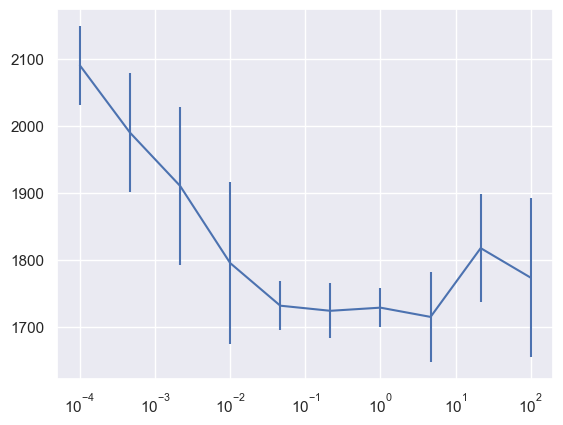

In [62]:
plt.errorbar(c_param, profit_mean, yerr = profit_std)
plt.xscale('log')

It seems like optimal regularization parameter is C = 0.0001 (we get the highest profit with this parametes) 

Попробуйте запустить перебор несколько раз. Находится ли каждый раз один и тот же "лучший" коэффициент? Присутствует ли какая-то закономерность? Какие вы можете сделать из этого выводы?

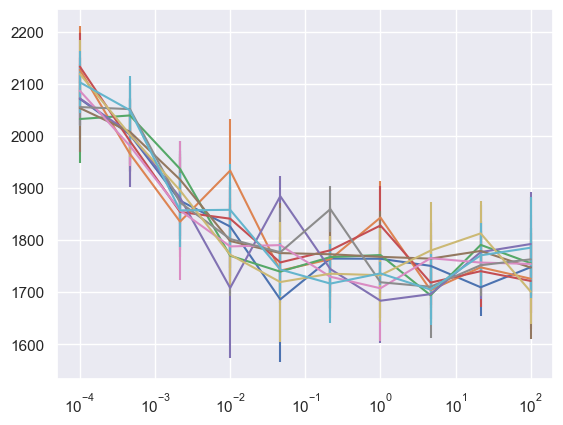

In [63]:
plt.figure()

for iter in range(10):
    profit_mean = []
    profit_std = []

    for c in c_param:
        profit = []
        for train_index, test_index in cv.split(y):
            
            X_train, X_test = X.loc[train_index, :], X.loc[test_index, :]
            y_train, y_test = y[train_index], y[test_index]
            
            transformer = ColumnTransformer(
                [
                    ('ohe', OneHotEncoder(handle_unknown='ignore'), cat_cols),
                    ('scaler', StandardScaler(), num_cols)
                ]
            )
            
            pipeline = Pipeline(
                [
                    ('transformer', transformer),
                    ('regression', LogisticRegression(C = c))
                ]
            )
            
            pipeline.fit(X_train, y_train)
            preds = pipeline.predict(X_test)
            
            profit.append(np.dot(mask, np.random.uniform(low=0, high=20, size=len(mask))) - np.sum(preds) * 1)
        #print(f'For C = {c} mean profit is {np.mean(profit)} with std = {np.std(profit)}')
        profit_mean.append(np.mean(profit))
        profit_std.append(np.std(profit))
    plt.errorbar(c_param, profit_mean, yerr = profit_std)
    plt.xscale('log')
    
    

Почти каждый раз лучший коэфициент - это $10^{-4}$. Закономерность на графике прослеживатеся. Из этого можно сделать вывод, что перебор коэфициент ведет себя примерно одинаково для разных итераций.

__Задание 11 (1.5 балл).__ Выше мы уже описали примерную экономическую модель вашей задачи. Как вы считаете, что для вашего бизнеса важнее — хороший precision или recall модели? Почему?

__Ответ:__


На неправильно предсказанном клиенте мы теряем 1 \$. При этом на правильно предсказанном зарабатываем намного больше - 9 \$. Очевидно, что нам важнее не пропустить клиентов, на которых мы потенциально можем заработать. Поэтому для модели важнее recall.


Вспомним, что на самом деле логистическая регрессия предсказывает нам вероятности (`predict_proba(...)`) положительного класса для объекта. Возможно, путем настройки порога бинаризации этих вероятностей мы сможем получить какой-то выигрыш? Проверьте ваши рассуждения выше с помощью настройки порога бинаризации на кросс-валидации для максимизации прибыли. Воспользуйтесь сеткой от 0 до 1 с шагом 0.01. Напомним, что снижение порога дает нам более высокий recall и более низкий precision, и наоборот.

In [64]:
thr = np.arange(0, 1, 0.01)

In [65]:
mean_profit = []
std_dev = []


for t in thr:
    profit = []
    for train_index, test_index in cv.split(y):
        X_train, X_test = X.loc[train_index, :], X.loc[test_index, :]
        y_train, y_test = y[train_index], y[test_index]
        
        transformer = ColumnTransformer(
            [
                ('ohe', OneHotEncoder(handle_unknown='ignore'), cat_cols),
                ('scaler', StandardScaler(), num_cols)
            ]
        )
        
        pipeline = Pipeline(
            [
                ('transformer', transformer),
                ('regression', LogisticRegression(C = 0.0001))
            ]
        )
        
        pipeline.fit(X_train, y_train)
        preds_proba = pipeline.predict_proba(X_test)[:, 1]
        preds = (preds_proba >= t)
        mask = ((preds == True) & (y_test == True))
        profit.append(np.dot(mask, np.random.uniform(low=0, high=20, size=len(mask))) - np.sum(preds) * 1)
    mean_profit.append(np.mean(profit))
    std_dev.append(np.std(profit))

Постройте график зависимости прибыли от порога бинаризации, также отметьте на нем стандартные отклонения. Выделите наилучший порог. 


__Вопрос:__ Замечаете ли вы какую-то закономерность? Для правильного ответа на этот вопрос попробуйте запустить несколько раз и задумайтесь, почему порог получается в какой-то конкретной области?

При многократных запусках пороги будут находиться примерно левее 0.2. Это подтверждает нашу гипотезу о том, что компании важнее precison, чем recall для максимизации прибыли.

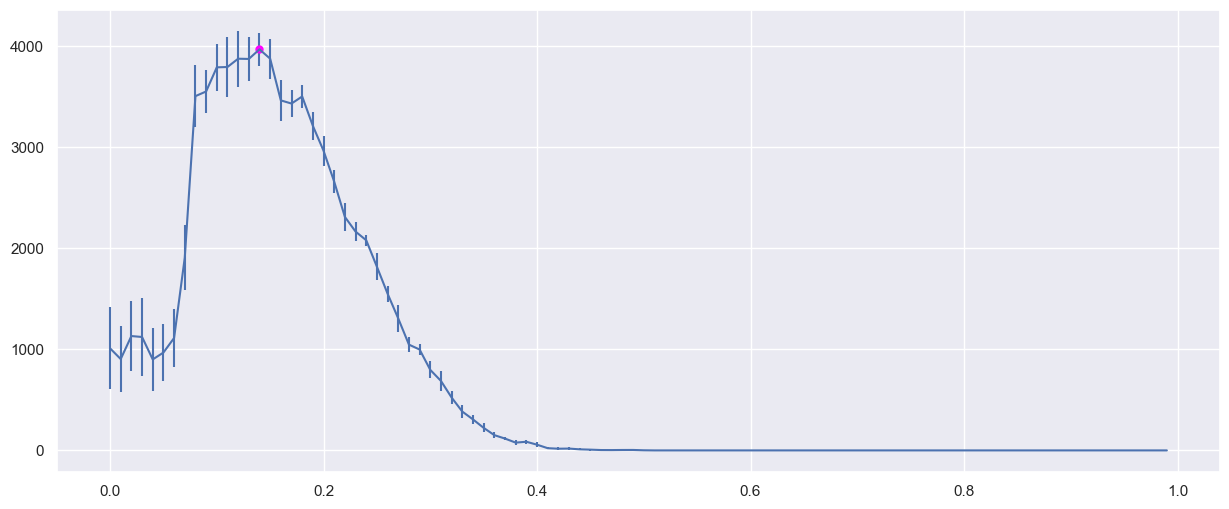

In [66]:
plt.figure(figsize=(15,6))

plt.errorbar(thr, mean_profit, std_dev)
plt.plot(thr[np.argmax(mean_profit)], max(mean_profit), marker='.', markersize=10, color='magenta')

Каковы значения precision и recall на выбранном пороге? Оцените по кросс-валидации. Также вычислите стандартное отклонение.

Поставим значение порога равным 0.14

In [67]:
from sklearn.metrics import precision_score, recall_score

In [68]:
pr = []
rec = []
for train_index, test_index in cv.split(y):
    X_train, X_test = X.loc[train_index, :], X.loc[test_index, :]
    y_train, y_test = y[train_index], y[test_index]
    
    transformer = ColumnTransformer(
        [
            ('ohe', OneHotEncoder(handle_unknown='ignore'), cat_cols),
            ('scaler', StandardScaler(), num_cols)
        ]
    )
    
    pipeline = Pipeline(
        [
            ('transformer', transformer),
            ('regression', LogisticRegression(C = 0.0001))
        ]
    )
    
    pipeline.fit(X_train, y_train)
    preds_proba = pipeline.predict_proba(X_test)[:, 1]
    preds = (preds_proba >= 0.14)
    
    pr.append(precision_score(y_test, preds))
    rec.append(recall_score(y_test, preds))

print(f'Mean precision is {np.mean(pr)} with std = {np.std(pr)}')

print(f'Mean recall  is {np.mean(rec)} with std = {np.std(rec)}')

        

Mean precision is 0.25678855112104604 with std = 0.00968198819589496
Mean recall  is 0.7011331228074836 with std = 0.009286815907652414


__Бонус (0.01 балла):__ что вы кушали в день сдачи данного ДЗ на завтрак?

__Ответ:__ Творог